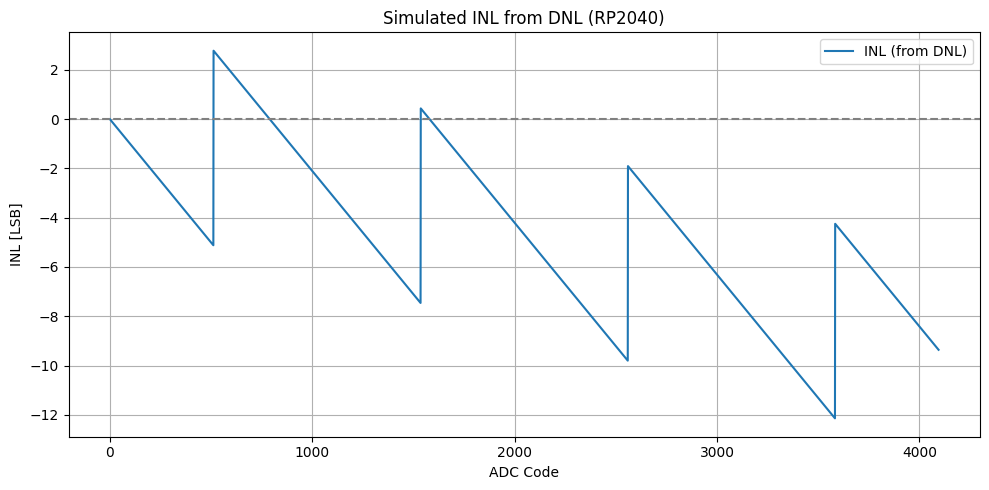

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# ADC 分解能（12bit）
adc_max = 4096

# 初期化：DNL配列（全体を1.0 LSBと仮定）
dnl = np.ones(adc_max)

# 特定ポイントでスパイク（+8.9 LSB）
spike_indices = [512, 1536, 2560, 3584]
for idx in spike_indices:
    dnl[idx] = 8.9

# INLはDNLの累積和（中央値基準に補正も可）
inl = np.cumsum(dnl - 1.01)  # -1.0は理想DNLとの差

# グラフ表示
plt.figure(figsize=(10, 5))
plt.plot(inl, label='INL (from DNL)')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Simulated INL from DNL (RP2040)")
plt.xlabel("ADC Code")
plt.ylabel("INL [LSB]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


3.2698961937716264
1.529100529100529


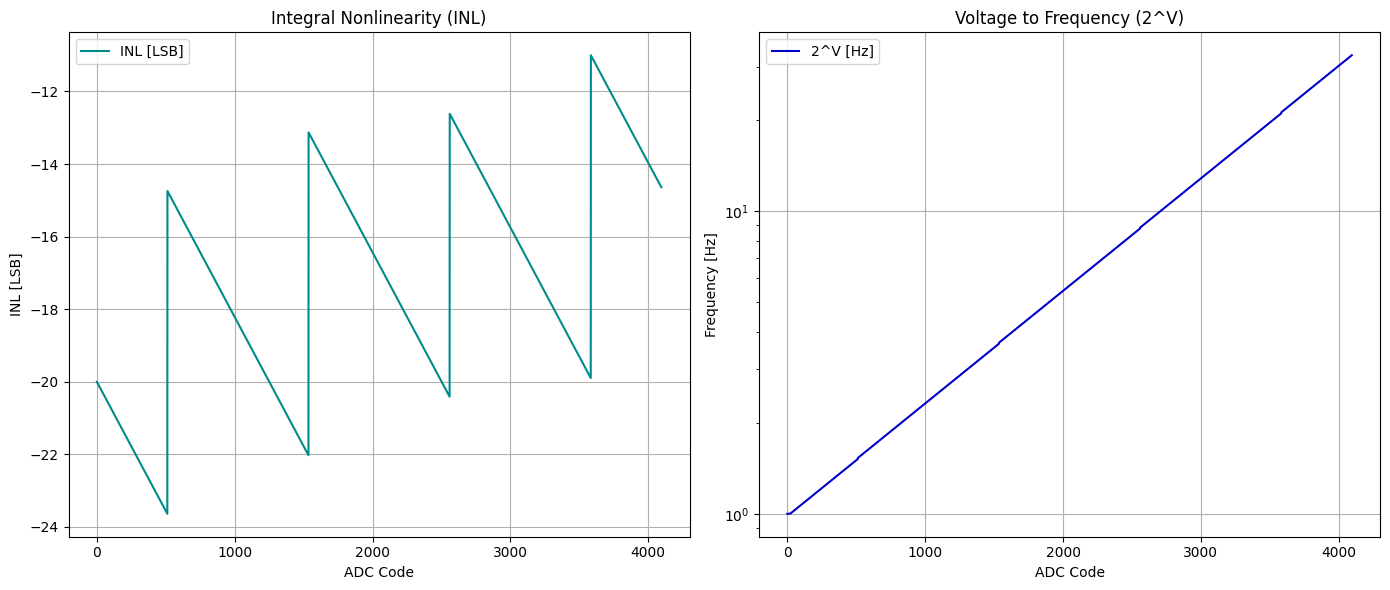

In [18]:
import matplotlib.pyplot as plt
import csv

def export_to_csv(_INL, _adc2powV, filename="./adc_correction_data.csv"):
    with open(filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["ADC Code", "INL (LSB)", "Frequency (Hz)"])
        for i in range(4096):
            writer.writerow([i, _INL[i], _adc2powV[i]])
    print(f"✅ CSVファイルに出力しました: {filename}")

def plot_graphs(_INL, _adc2powV):
    x = list(range(4096))

    plt.figure(figsize=(14, 6))

    # INL グラフ
    plt.subplot(1, 2, 1)
    plt.plot(x, _INL, label='INL [LSB]', color='darkcyan')
    plt.title("Integral Nonlinearity (INL)")
    plt.xlabel("ADC Code")
    plt.ylabel("INL [LSB]")
    plt.grid(True)
    plt.legend()

    # pow(2, V/OCT) グラフ
    plt.subplot(1, 2, 2)
    plt.plot(x, _adc2powV, label='2^V [Hz]', color='mediumblue')
    plt.title("Voltage to Frequency (2^V)")
    plt.xlabel("ADC Code")
    plt.ylabel("Frequency [Hz]")
    plt.yscale("log")  # 対数スケールの方が音階的に自然
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


_INL = [0 for i in range(4096)]
_adc2powV = [0 for i in range(4096)]
_correctedAdc = [0 for i in range(4096)]

_inputMax = 5.0
_adcInputMax = 189000.0 / (100000.0 + 189000.0) * _inputMax
_voctInputRatio = _inputMax / _adcInputMax
_inlRatio = -0.012
_adcInputRatio = 1.0

print(_adcInputMax)
print(_voctInputRatio)

def generateINL(noiseFloor = 0.0):
    spikes = [512, 1536, 2560, 3584]
    spikeLSBs = [8.9, 8.9, 7.8, 8.9]

    for i in range(4096):
        _INL[i] = (_inlRatio * i) - (noiseFloor - ((noiseFloor / 4095) * i))
        # if (noiseFloor > 0.0):
        #     _INL[i] = (-0.009 * i) - (noiseFloor - (noiseFloor * (i / 4095.0)))
        # else:
        #     _INL[i] = (-0.01 * i)

    for i in range (4):
        spike_pos = spikes[i]
        for j in range(spike_pos, 4096):
            # _INL[j] += spikeLSBs[i]
            if spike_pos > j:
                _INL[j] += spikeLSBs[i] / 2.0
            else:
                _INL[j] += spikeLSBs[i]

def constrain(val, min, max):
    if (val < 0):
        return min
    if (val > max):
        return max
    return val

def generate(vref = 3.3):
    lsb_voltage = vref / 4095.0

    for adc in range(4096):
        correctedAdc = adc + _INL[adc]
        correctedAdc = constrain(correctedAdc, 0.0, 4095.0)
        voltage = correctedAdc * lsb_voltage
        voct = voltage * _voctInputRatio
        _correctedAdc[adc] = correctedAdc * _adcInputRatio
        _adc2powV[adc] = pow(2, voct)


generateINL(20)
generate(3.3038)
plot_graphs(_INL, _adc2powV)
# export_to_csv(_INL, _adc2powV)

In [ ]:
adc = 4033
_inputMax = 5.0
_adcInputMax = 189000.0 / (100000.0 + 189000.0) * _inputMax
_voctInputRatio = _inputMax / _adcInputMax
vref = (_adcInputMax * 4095.0) / adc

print(f'adc:{adc} _inputMax:{_inputMax} _adcInputMax:{_adcInputMax:.4f} _voctInputRatio:{_voctInputRatio:.4f} vref:{vref:.4f}')





adc:4033 _inputMax:5.0 _adcInputMax:3.2699 _voctInputRatio:1.5291 vref:3.3202


1.015373171336474